In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/iris.csv')

In [3]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
df.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [5]:
species_list = list(df.Species.unique())
species_dict = dict(zip(species_list, range(6)))

In [6]:
species_id = np.zeros(df.Id.count())
for i in range(species_id.shape[0]):
    species_id[i] = species_dict[df.Species.iloc[i]]


In [7]:
df['Species'] = species_id.astype(int)

In [8]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0


array([[<AxesSubplot:title={'center':'SepalLengthCm'}>,
        <AxesSubplot:title={'center':'SepalWidthCm'}>],
       [<AxesSubplot:title={'center':'PetalLengthCm'}>,
        <AxesSubplot:title={'center':'PetalWidthCm'}>],
       [<AxesSubplot:title={'center':'Species'}>, <AxesSubplot:>]],
      dtype=object)

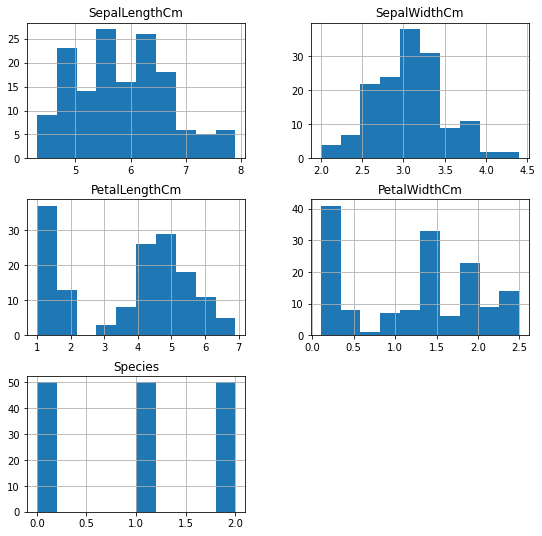

In [9]:
df = df.drop(columns='Id')
df.hist(figsize=(9,9))

In [10]:
df.loc[df.PetalWidthCm < 0.1]

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species


In [11]:
df.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,1.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


<AxesSubplot:>

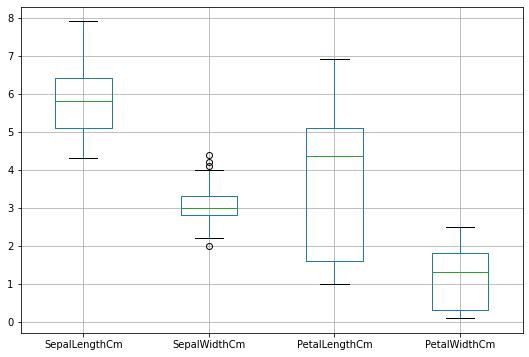

In [12]:
df.drop(columns=['Species']).boxplot(figsize=(9,6))

In [13]:
interq_dist = df.SepalWidthCm.quantile(0.75) - df.SepalWidthCm.quantile(0.25)
min_border = df.SepalWidthCm.quantile(0.25) - 1.5*interq_dist
max_border = df.SepalWidthCm.quantile(0.75) + 1.5*interq_dist
df = df.loc[(df.SepalWidthCm >= min_border) & (df.SepalWidthCm <= max_border)]

<AxesSubplot:>

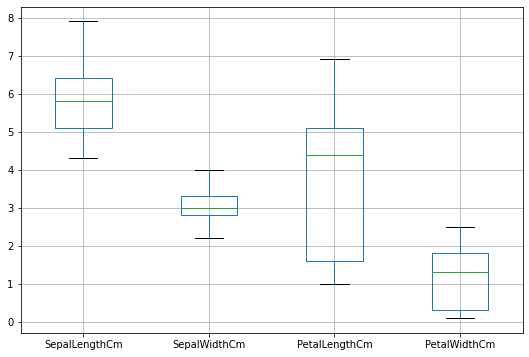

In [14]:
df.drop(columns=['Species']).boxplot(figsize=(9,6))

<AxesSubplot:>

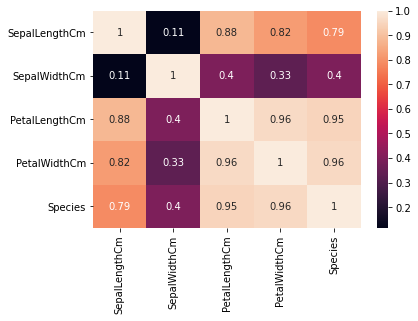

In [15]:
sns.heatmap(abs(df.corr()), annot=True)

In [16]:
from sklearn.ensemble import RandomForestClassifier

<AxesSubplot:>

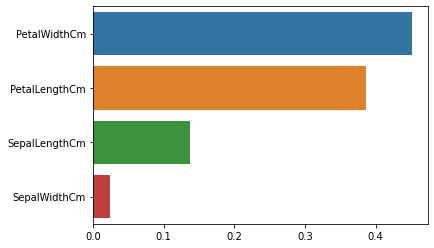

In [17]:
clf = RandomForestClassifier(criterion='entropy', n_estimators=50)
clf.fit(df.drop(columns=['Species']), df.Species)
feature_importances = clf.feature_importances_

sorted_ind = np.argsort(feature_importances)
sorted_ind = sorted_ind[::-1]
feature_importances = feature_importances[sorted_ind]

features = np.array(list(df.drop(columns=['Species'])))
features = features[sorted_ind]

sns.barplot(x=feature_importances, y=features)

In [19]:
print("Сумарный вклад в IG атрибутов  PetalLengthCm и PetalWidthCm", np.sum(feature_importances[:2]))

Сумарный вклад в IG атрибутов  PetalLengthCm и PetalWidthCm 0.8376427267066195


In [20]:
X = df.values[:,:-1]
Y = df.values[:, -1]
features_n = X.shape[1]
n = X.shape[0]
classes_n = 3

In [21]:
def calc_metric(X):
    features_n = X.shape[1]
    R_inter = np.zeros((features_n, features_n))
    Xm = np.mean(X, axis=0)
    for i in range(features_n):
        for j in range(features_n):
            for k in range(n):
                R_inter[i,j] += (X[k, i] - Xm[i]) * (X[k, j] - Xm[j])
    R_inter /= n

    R_inner = np.zeros((classes_n, features_n,features_n))
    for l in range(classes_n):
        Xl = X[Y == l]
        Xm = np.mean(Xl, axis=0)
        Nl = Xl.shape[0]
        for i in range(features_n):
            for j in range(features_n):
                for k in range(Nl):
                    R_inner[l,i,j] += (Xl[k, i] - Xm[i]) * (Xl[k, j] - Xm[j])
        R_inner[l] /= Nl

    R_inner = np.mean(R_inner, axis=0)

    metric = np.trace(R_inter) / np.trace(R_inner)

    return metric

In [28]:
print("Оценка качества пространства из всех признаков")
print("Метрика равна:", calc_metric(X))
print("\nОценка качества пространства из признаков SepalWidthCm, PetalLengthCm, PetalWidthCm")
print("Метрика равна:", calc_metric(np.concatenate((X[:, :1], X[:, 2:]), axis=1)))
print("\nОценка качества пространства из признаков PetalLengthCm, PetalWidthCm")
print("Метрика равна:", calc_metric(X[:, 2:]))

Оценка качества пространства из всех признаков
Метрика равна: 7.86891403142311

Оценка качества пространства из признаков SepalWidthCm, PetalLengthCm, PetalWidthCm
Метрика равна: 9.169016365770007

Оценка качества пространства из признаков PetalLengthCm, PetalWidthCm
Метрика равна: 16.53953669585818


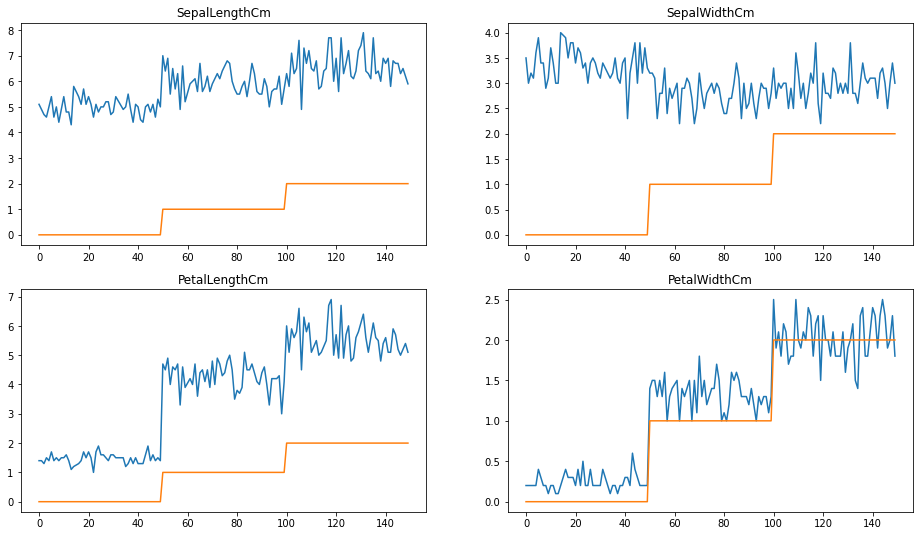

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16,9))
for i in range(2):
    for j in range(2):
        axes[i,j].plot(df.iloc[:, 2*i+j])
        axes[i,j].plot(df.iloc[:, -1])
        axes[i,j].set(title=list(df)[2*i+j])
